# Kaggle Spaceship Titanic Competition

This notebook will walk through the process I took to build, train, and tune a model to predict transported passengers on the Spaceship Titanic.

The data has already been seperated into training and testing sets.  The training set includes the outcome variable (Transported) and the testing set does not.  The goal is to build a model that can predict the outcome variable for the testing set.

The initial steps were done by just looking at the data and attempting to build and tune an accuracte model. 
This included:
- Understanding the data
- feature engineering
- basic imputation
- building a model
- tuning the model

After this, I looked at some of the top notebooks on Kaggle to see what I could learn from them.  I found that many of them used more advanced imputation techniques. I then went back and tried to implement some of these techniques to see if I could improve my model.

The two notebooks which were studied were:
- https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models
- https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

The first notebook was very helpful in understanding the data and the second notebook was very helpful in understanding how to implement more advanced imputation techniques.

Additionally, the findings in these notebooks were helpful for identify correlations between features which could aid in more accurate imputation of null  values.


In addition to the two notebooks noted above, Github co-pilot was used to help with the code


# Import Packages

In [49]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# we will disable warnings for clearer outputs
warnings.filterwarnings("ignore")

# import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    GradientBoostingClassifier,
)

# Data Cleaning and EDA

Lets start by taking a look at our dataset

In [50]:
# Load the data
test_df = pd.read_csv("../data/spaceship_titanic/test.csv")
train_df = pd.read_csv("../data/spaceship_titanic/train.csv")
submission_csv = pd.read_csv("../data/spaceship_titanic/sample_submission.csv")

In [51]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [52]:
print(
    f"The train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns\n"
)
train_df.info()

The train dataset has 8693 rows and 14 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Our dataset has 5 cateogrical variables, 6 numerical variables, and 3 descriptive variables.

**Categorical Variables:**
- HomePlanet
- CryoSleep
- Destination
- VIP
- Transported

**Numerical Variables:**
- Age
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

**Descriptive Variables:**
- PassengerId
- Cabin
- Name


## Value of Interest: Transported

In [53]:
train_df["Transported"].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

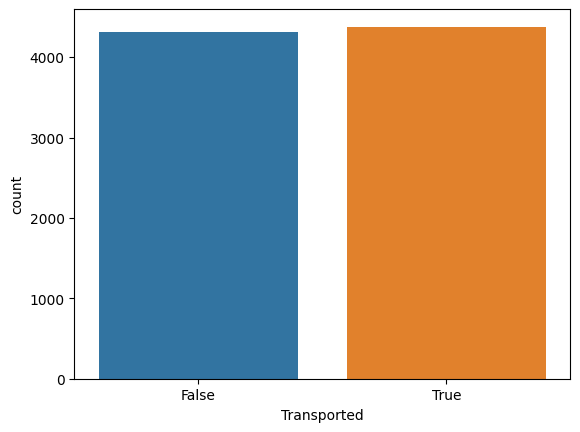

In [54]:
sns.countplot(x="Transported", data=train_df)
plt.show()

Our goal is to predict whether or not a passenger is transported.

The numbert of passengers tranported and not transported are very similar with no significant difference.

Transported: 4378
Not Transported: 4315



## Feature Engineering

### Cabin Information

The cabin variable is a string which includes the cabin number, side, and the deck.  We can extract the deck information from this variable and create new variables called Deck, Side, CabinNum.

In [55]:
def seperate_cabin_data(df):
    """
    This function will seperate the cabin data into three columns: Deck, CabinNum, and Side

    Parameters
    ----------
    df: pandas dataframe
        The dataframe that contains the cabin data

    Returns
    -------
    df: pandas dataframe
        The dataframe that contains the cabin data seperated into three columns
    """
    df["Cabin"] = df["Cabin"].str.split("/")
    df["Deck"], df["CabinNum"], df["Side"] = (
        df["Cabin"].str[0],
        df["Cabin"].str[1].astype(float),
        df["Cabin"].str[2],
    )
    df.drop("Cabin", axis=1, inplace=True)
    return df

In [56]:
# Seperate Cabin into Deck, Room, Side
test_df = seperate_cabin_data(test_df)
train_df = seperate_cabin_data(train_df)

Additionally, we can create a new variable which combines all the spending categories into one total spendings category.

In [57]:
def calc_total_spending(df):
    """
    This function will calculate the total spending of each passenger

    Parameters
    ----------
    df: pandas dataframe
        The dataframe that contains the spending data

    Returns
    -------
    df: pandas dataframe
        The dataframe that contains the total spending data
    """
    df["TotalSpending"] = (
        df["RoomService"]
        + df["FoodCourt"]
        + df["ShoppingMall"]
        + df["Spa"]
        + df["VRDeck"]
    )
    return df

In [58]:
# Create total spending column
train_df = calc_total_spending(train_df)
test_df = calc_total_spending(test_df)

### Family Size

Here we are making the assumption that if the passengers have the same last name that they are a part of the same family. The family size is the number of people in the family including the passenger.

This data is added in a new column `FamilySize`.

In [59]:
def find_family_size(df):
    df["FamilyName"] = df["Name"].str.split(" ").str[1]
    df["FamilySize"] = df.groupby("FamilyName")["FamilyName"].transform(
        "count"
    )
    df.drop("FamilyName", axis=1, inplace=True)
    return df

In [60]:
train_df = find_family_size(train_df)
test_df = find_family_size(test_df)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0,4.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0,6.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0,6.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0,6.0


We now have 18 columns in our dataset.

### Passenger Group and Number of people in group

The PassengerId follows the format gggg_pp where gggg is the group number and pp is the number of people in the group. This data is added in a new column `PassengerGroup` and `GroupSize`.

In [61]:
def find_group_info(df):
    """
    This function will find the group size and group number of each passenger

    Parameters
    ----------
    df: pandas dataframe
        The dataframe that contains the passenger id

    Returns
    -------
    df: pandas dataframe
        The dataframe that contains the group size and group number of each passenger
    """
    df["GroupSize"] = df["PassengerId"].str.split("_").str[1].astype(int)
    df["GroupNum"] = df["PassengerId"].str.split("_").str[0].astype(int)
    return df

In [62]:
train_df = find_group_info(train_df)
test_df = find_group_info(test_df)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize,GroupSize,GroupNum
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0,1.0,1,1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0,4.0,1,2
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0,6.0,1,3
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0,6.0,2,3
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0,6.0,1,4


There are now 20 columns in our dataset

# Exploritory Data Analysis

## Numerical Variables

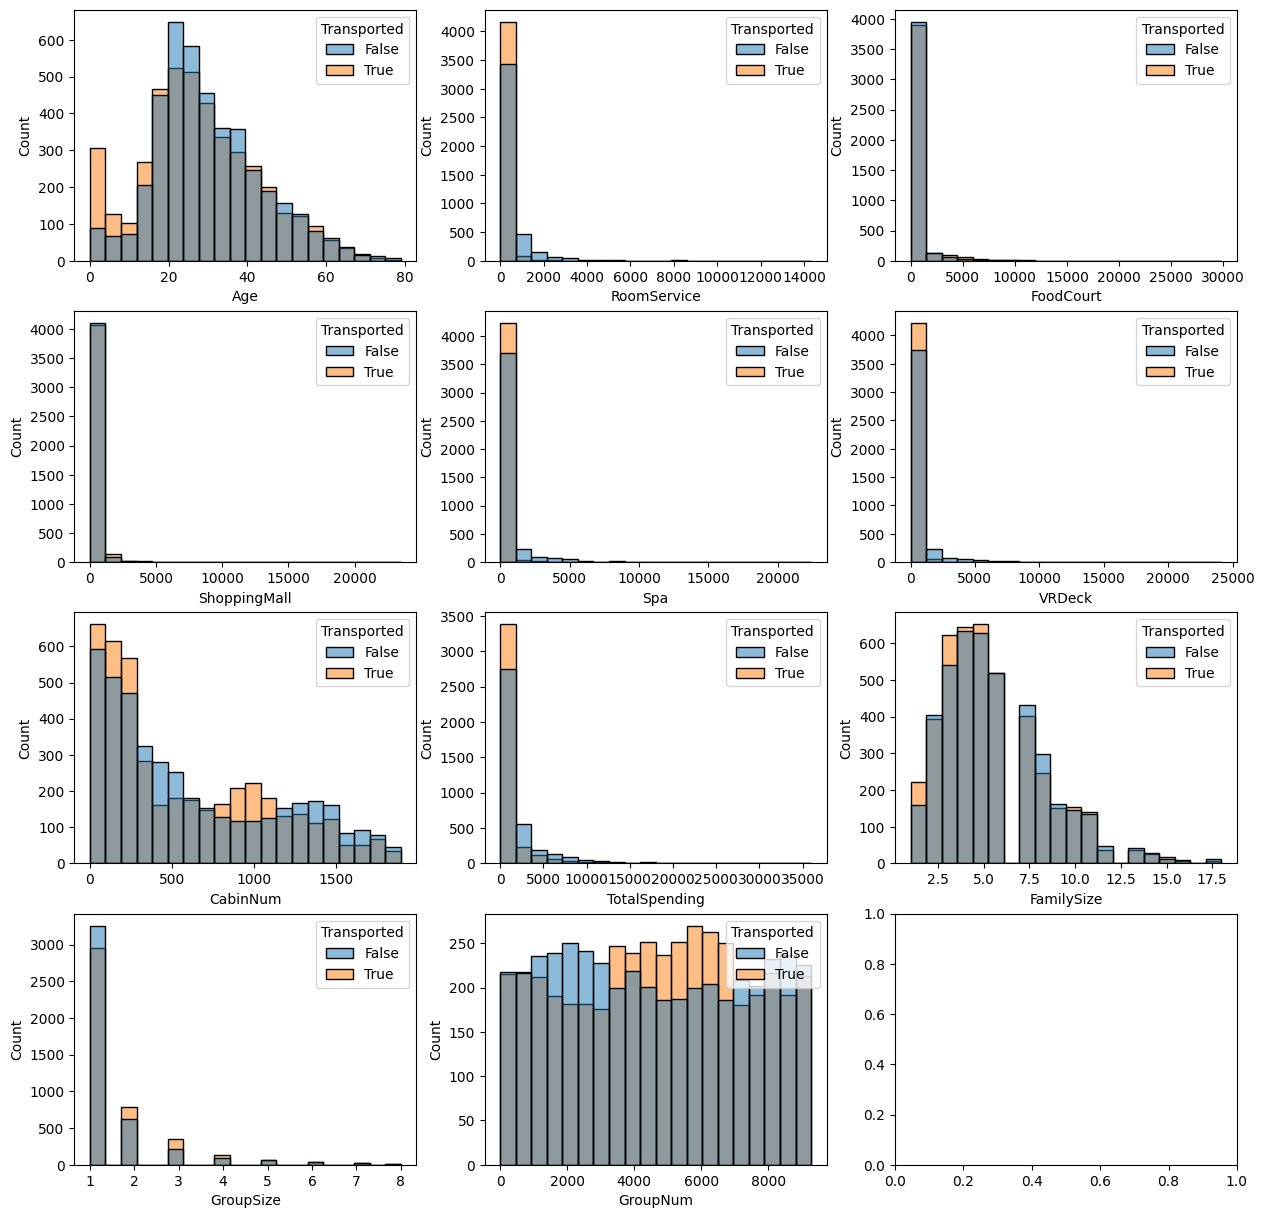

In [63]:
numeric_vars = train_df.select_dtypes(include="number").columns.tolist()

# Creates histograms for all numeric variables with seperate by Transported
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    if i < len(numeric_vars):
        sns.histplot(
            data=train_df,
            x=numeric_vars[i],
            hue="Transported",
            ax=ax,
            bins=20,
        )

### Spending Categories

There are 6 spending categories: **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**, and **TotalSpending**

Based on the distributions of our numerical variables, we can see that the spending categories are skewed to the right. This is expected as most people will spend less than the average. The distributions of the spending categories are similar to each other. The distributions of the spending categories are also similar to the distribution of the total spending. This is expected as the spending categories are a subset of the total spending.

These Columns may benefit from a log transformation or being split into bins.

The passengers with the lowest spending for TotalSpending, VRDeck, Spa, and RoomService appear to have a higher rate of being transported, while those with the lowest spending for ShoppingMall and FoodCourt appear to have a lower rate of being transported.

In [64]:
spending_cats = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpending",
]
train_df[spending_cats].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,7785.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791,1484.601541
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2845.288241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,736.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000,1486.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


We can see that for all spending categories most passengers spent 0 at all categories.

 We will create a new variable in the dataset for passengers who didnt spend any money on the ship. This will calculted using `TotalSpening` and will be called `NoSpending`.

In [65]:
train_df["NoSpending"] = train_df["TotalSpending"] == 0
test_df["NoSpending"] = test_df["TotalSpending"] == 0

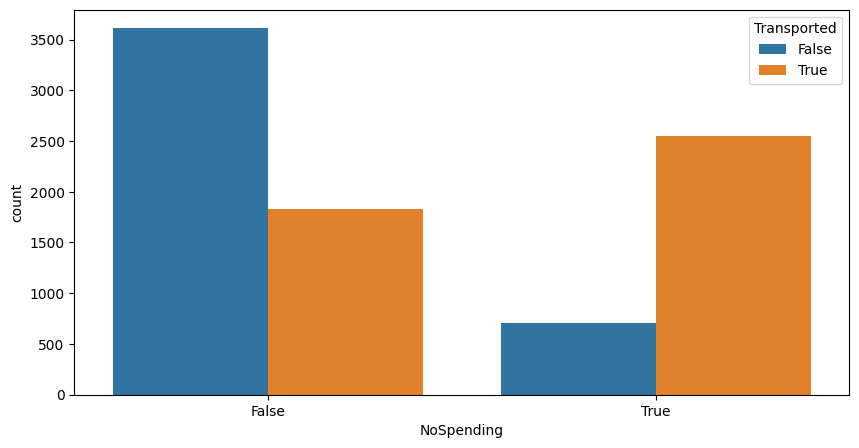

In [66]:
plt.figure(figsize=(10, 5))
sns.countplot(x="NoSpending", data=train_df, hue="Transported")
plt.show()

Since the distribution of the spending categories are similar to each other and  all the categories are signifigantly skewed, we will use a log transformation to normalize the data. This wall happend after we impute null values to make our imputations more accurate.

### Age
Based on the distribution of Age it appears that those with an age of less than 20 were more likely to be transported.

Passengers with an age between 20 and 40 were more likely to be transported.

Passengers with an age greater than 40 showed less difference for those transported and those not. 

### Cabin Number
The distribution of Cabin number reveals interesting information for being transported or not. 

Passsengers with cabin numbers between 0 and 250, and 750 and 1100 were more likely to be transported. Passengers not within those ranges were less likely to be transported. 

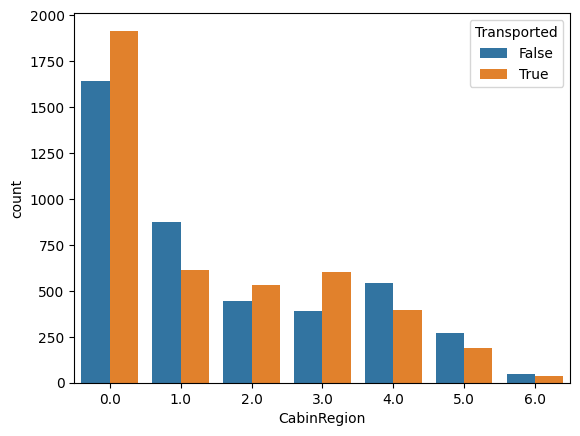

In [67]:
# based on the distribution of cabin numbers we can bin the cabin numbers to make the data more categorical
# This is a techinque found by Kaggle user: https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide
# Based on their analysis they found that the cabin regions are seperated into distinct groups of 300

# New column CabinRegion will be created to hold the binned cabin numbers by 300
train_df["CabinRegion"] = train_df["CabinNum"] // 300
test_df["CabinRegion"] = test_df["CabinNum"] // 300

sns.countplot(data=train_df, x="CabinRegion", hue="Transported")
plt.show()

### Family Size

Based on the distribution of Family Size, it appears that passengers with a family size less than 5 were more likely to be transported. 

The difference between passengers who were transported and not is smaller for Family size than other  variables

### Group Size

Passengers with a groupsize (as indicated by their ticket) of 1, were less likely to be transported. 

Those with a group size greater than 1 were more likely to be transported.



## Categorical Variables

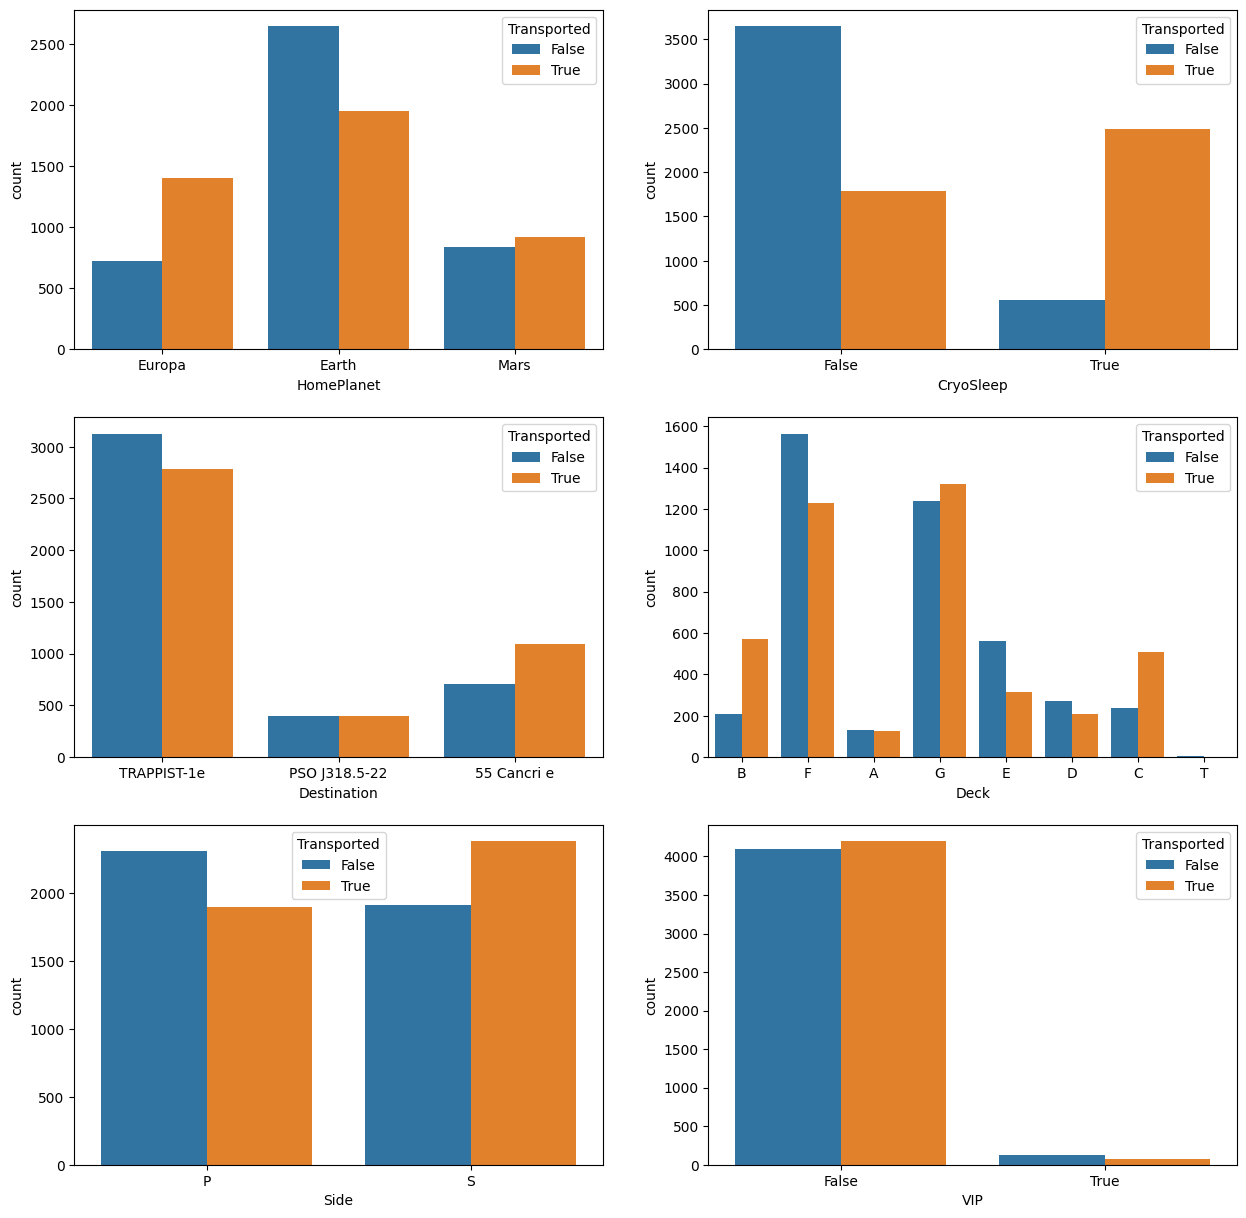

In [68]:
# Take out spending cateogries and transported as they have already been analyzed
cat_vars = ["HomePlanet", "CryoSleep", "Destination", "Deck", "Side", "VIP"]

# Creates bar plots for all categorical variables with seperate by Transported
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    if i < len(cat_vars):
        sns.countplot(
            data=train_df,
            x=cat_vars[i],
            hue="Transported",
            ax=ax,
        )

## Eliminating Variables

### Cabin
The Cabin variable has been previously eliminated in favor of the Deck, Side, and Num variables that were created from it.

### PassengerId
The PassengerId variable is a unique identifier for each passenger and will not be useful in our model.

### Name
The Name variable is a unique identifier for each passenger and will not be useful in our model.


In [69]:
train_df.drop(["Name", "PassengerId"], axis=1, inplace=True)

test_df.drop(["Name", "PassengerId"], axis=1, inplace=True)

train_df.head()

,HomePlanet,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize,GroupSize,GroupNum,NoSpending,CabinRegion
0,Europa,False,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,0.0,1.0,1,1,True,0.0
1,Earth,False,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,736.0,4.0,1,2,False,0.0
2,Europa,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,10383.0,6.0,1,3,False,0.0
3,Europa,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,5176.0,6.0,2,3,False,0.0
4,Earth,False,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,1091.0,6.0,1,4,False,0.0


# Null Value Imputation

we will create clusters with our data, then impute null values with the median from the cluster they are in

In [70]:
# Resetablish our numeric and categorical variables with the dropped columns
numeric_vars = train_df.select_dtypes(include="number").columns.tolist()
cat_vars = train_df.select_dtypes(exclude="number").columns.tolist()

In [71]:
# All columns have missing values except for transported
train_df.isna().sum()

HomePlanet       201
CryoSleep        217
Age              179
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Transported        0
Deck             199
CabinNum         199
Side             199
TotalSpending    908
FamilySize       200
GroupSize          0
GroupNum           0
NoSpending         0
CabinRegion      199
dtype: int64

We can see that there are a signifigant amount of null values in most of the columns of this dataset. How we impute these values will depend on the column

### Home Planet and Group

Kaggle User https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

They found that there was a correlation between group number and homeplanet

We will use these findings to impute the missing values for home planet

In [72]:
train_df["HomePlanet"] = train_df.groupby("GroupNum")["HomePlanet"].transform(
    lambda x: x.fillna(x.mode())
)

### Spending Categories

For the shopping categories we will impute the null values with the mean of the group they are in.

We  choose to use the mean for the spending categories since the median is often 0 for the categories.

In [73]:
it_imp = SimpleImputer(strategy="mean")

# fit imputer to spending categories and transform training and test data
for col in train_df.columns:
    if col in spending_cats:
        # fit imputer to training data
        it_imp.fit(train_df[[col]])

        # transform training and test data
        train_df[col] = it_imp.transform(train_df[[col]])
        test_df[col] = it_imp.transform(test_df[[col]])

### Numerical and Categorical Variables

For the ramainder of the variables we will impute numerical variables with the median and categorical variables with the mode.

We will use an iterative imputer to impute the null values for the numerical variables, in the hope of getting better results.

#### Categorical

In [74]:
# Impute missing values with mode for categorical in test and training datasets
for col in train_df.columns:
    if col in cat_vars:
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

for col in test_df.columns:
    if col in cat_vars:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

#### Numerical

In [75]:
# Initialize our iterative imputer
it_imp = IterativeImputer(
    initial_strategy="median", random_state=42, max_iter=10
)


# fit imputer to numeric variables and transform training and test data

it_imp.fit(train_df[numeric_vars])
train_df[numeric_vars] = it_imp.transform(train_df[numeric_vars])

test_df[numeric_vars] = it_imp.transform(test_df[numeric_vars])

In [76]:
# Check for missing values in the whole data set
train_df.isna().sum().sum()

0

There are no more null values in the dataset so we are able to move on to our log transformation and model building

# Log Transformation

Now that we have handled the null values we will perform a log transformation on the spending categories, to normalize the data and reduce the extreme right skew.

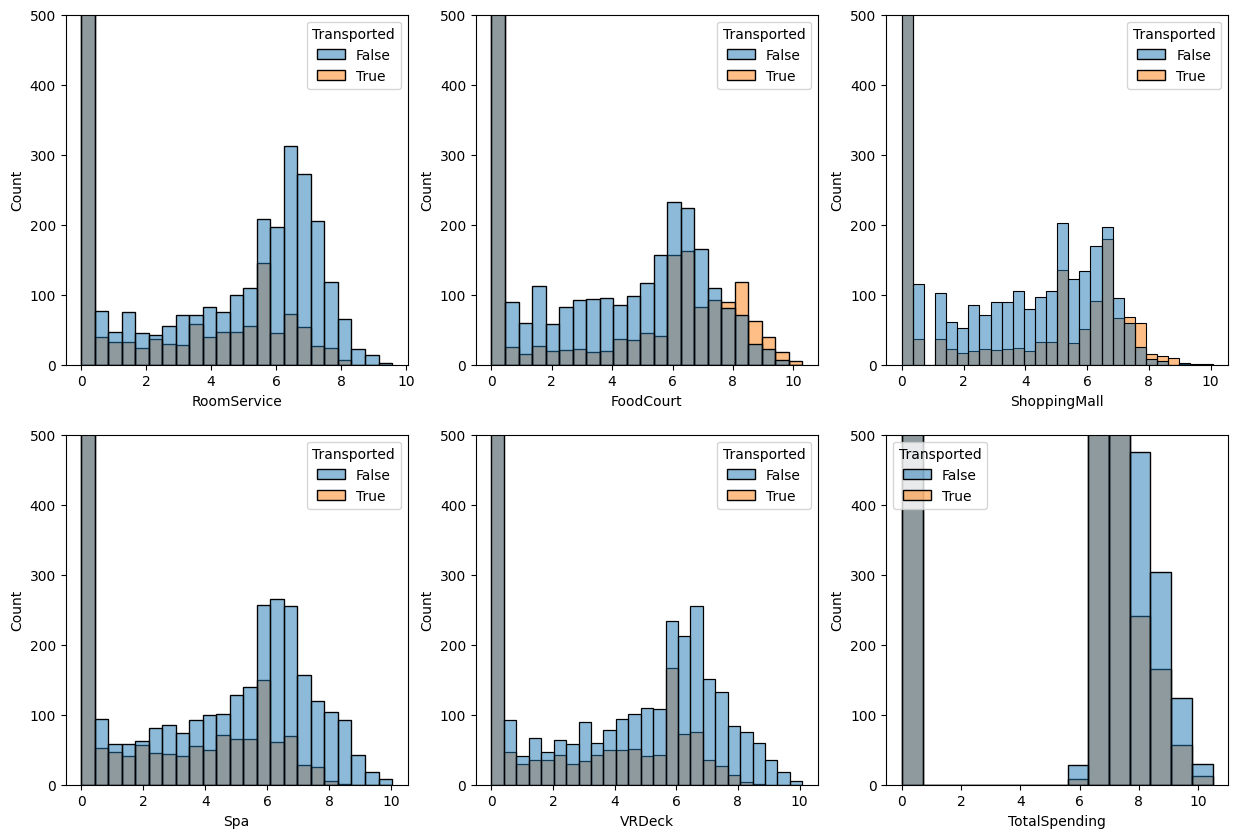

In [77]:
spending_cats = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpending",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={"ylim": (0, 500)})

# Log transform the spending data
for col in spending_cats:
    train_df[col] = train_df[col].apply(lambda x: np.log(x + 1))
    test_df[col] = test_df[col].apply(lambda x: np.log(x + 1))

# plot the transformed data
for i, ax in enumerate(axes.flatten()):
    sns.histplot(data=train_df, x=spending_cats[i], hue="Transported", ax=ax)

plt.show()

# Model Training

## Label Seperation

In [78]:
# Our labels are the transported column
labels = ["Transported"]

# Remove labels from cat_vars
cat_vars.remove(labels[0])

# Our features are everything else
X = train_df.copy().drop(labels, axis=1)

y = train_df[labels]

## Preprocessing

In [79]:
# One hot encode categorical variables and scale numerical variables
preprocess = ColumnTransformer(
    [
        ("OneHot", OneHotEncoder(), cat_vars),
        ("scale", StandardScaler(), numeric_vars),
    ]
)

X_prep = preprocess.fit_transform(X)

Our categorical variables will be encoded using one hot encoding, and our numerical variables will be scaled using standard scaling.

## Parameter Tuning

We will use 4 different classifiers and tune their parameters to find the best model.

To tune the models we will use a grid search with 5 fold cross validation.

A grid of parameters can be seen below for testing.

In [80]:
# make a list of classifiers and params to iterate through in order to determine the best model
classifiers = {
    "lr": LogisticRegression(),
    "rf": RandomForestClassifier(),
    "svm": SVC(),
    "grad": GradientBoostingClassifier(),
}

params = {
    "lr_params": {
        "C": [0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
    },
    "rf_params": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, 15, 20],
        "min_samples_leaf": [1, 2, 3],
    },
    "svm_params": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "grad_params": {
        "n_estimators": [100, 200],
        "learning_rate": [0.1, 0.5],
        "max_depth": [3, 5],
    },
}

In [81]:
from sklearn.model_selection import GridSearchCV

for class_name, classifier in classifiers.items():
    grid_clf = GridSearchCV(
        estimator=classifier,
        param_grid=params[class_name + "_params"],
        cv=10,
        scoring="accuracy",
        n_jobs=-1,
    )

    grid_clf.fit(X_prep, y)
    print(f"Best parameters for {class_name}: {grid_clf.best_params_}")
    print(f"Best score for {class_name}: {grid_clf.best_score_}")
    print()

Best parameters for lr: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for lr: 0.7768361043873921

Best parameters for rf: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 100}
Best score for rf: 0.7842014205785484

Best parameters for svm: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for svm: 0.8009950663333465

Best parameters for grad: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score for grad: 0.7611908257608825



## Voting Model

The results of our parameter selection/tuning will be used to create a voting model.

This model will then be fit to our training data and used to predict the test data.

In [82]:
voting_clf = VotingClassifier(
    estimators=[
        (
            "lr",
            LogisticRegression(
                C=0.1, penalty="l1", solver="liblinear", random_state=42
            ),
        ),
        (
            "rf",
            RandomForestClassifier(
                random_state=42,
                max_depth=20,
                min_samples_leaf=3,
                n_estimators=200,
            ),
        ),
        ("svm", SVC(C=1, gamma="scale", kernel="poly", random_state=42)),
        (
            "gradient",
            GradientBoostingClassifier(
                learning_rate=0.1,
                max_depth=3,
                n_estimators=100,
                random_state=42,
            ),
        ),
    ],
    voting="hard",
)

In [83]:
voting_clf.fit(X_prep, y)
voting_clf.score(X_prep, y)

0.8373403888185896

## Results

Our tuned model was able to achieve an accuracy score of 0.8401 using out training data. This is a significant improvement over our baseline model.

When submitted to kaggle we are able to get an accuracy of 0.7978 for the test data. 

If we wanted to improve the accuracy of the model further, we could try to find a better way to impute the null values, based on other variables in the dataset.

# Submission

We will use the sample_submission.csv file to create our submission file.

The transported column of the sample submission will be overwritten with our predictions allowing the predicted values to allign with the correct order of passenger ids.

In [84]:
submission = pd.read_csv("../data/spaceship_titanic/sample_submission.csv")

In [85]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


Now that we have the submission dataframe, we can use the model to predict the transported column and use it to replace the values in the sample submission

In [86]:
X = preprocess.transform(test_df)

y_pred = voting_clf.predict(X)

In [87]:
submission["Transported"] = y_pred
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


We will then write these results to a csv and submit to kaggle

In [88]:
submission.to_csv("../data/spaceship_titanic/submission.csv", index=False)